100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


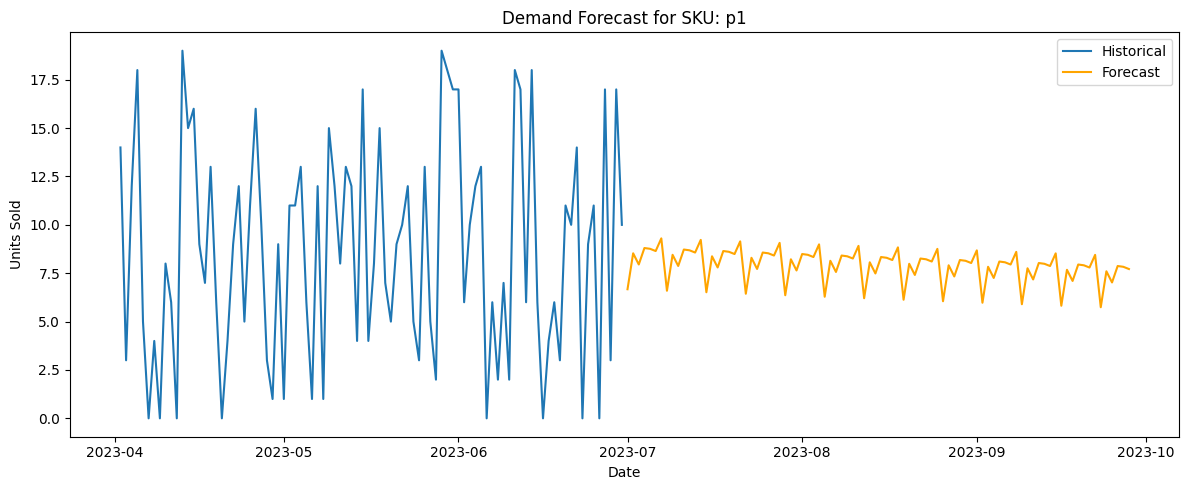

In [5]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Step 2: Load cleaned dataset
df = pd.read_excel("Model Sample Data - Retail Inventory.xlsx", sheet_name="Sales_Transactions")
df['Date'] = pd.to_datetime(df['Date'])

# Step 3: Prepare daily sales per SKU
sku_dfs = {}
all_forecasts = []

forecast_horizon = 90  # days

for sku in tqdm(df['SKU'].unique()):
    sku_df = df[df['SKU'] == sku].copy()
    sku_df = sku_df.groupby('Date')['Quantity'].sum().asfreq('D').fillna(0)
    
    try:
        model = ExponentialSmoothing(
            sku_df,
            seasonal='add',
            seasonal_periods=7,  # weekly seasonality
            trend='add'
        ).fit()

        forecast = model.forecast(forecast_horizon)
        forecast_df = pd.DataFrame({
            'Date': forecast.index,
            'SKU': sku,
            'Forecasted_Demand': forecast.values
        })

        all_forecasts.append(forecast_df)
    except Exception as e:
        print(f"Skipping {sku} due to: {e}")
        continue

# Step 4: Combine all forecasts
forecast_df = pd.concat(all_forecasts).reset_index(drop=True)

# Step 5: Export for inventory simulation
forecast_df.to_csv("category_forecasts.csv", index=False)

# Step 6: (Optional) Visualize forecast for 1 sample SKU
sample_sku = df['SKU'].unique()[0]
sku_df = df[df['SKU'] == sample_sku].copy()
sku_df = sku_df.groupby('Date')['Quantity'].sum().asfreq('D').fillna(0)

model = ExponentialSmoothing(
    sku_df,
    seasonal='add',
    seasonal_periods=7,
    trend='add'
).fit()

forecast = model.forecast(forecast_horizon)

plt.figure(figsize=(12, 5))
plt.plot(sku_df[-90:], label='Historical')
plt.plot(forecast, label='Forecast', color='orange')
plt.title(f'Demand Forecast for SKU: {sample_sku}')
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.tight_layout()
plt.show()
